In [13]:
import sys
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pylab as plt
import sys, os
import pickle
sys.path.append(r'C:\Users\vhbncm\Desktop\3학년1학기 공부\밑바닥딥러닝\deep-learning-from-scratch-2-master\deep-learning-from-scratch-2-master') # 부모 디렉토리의 파일을 가져올 수 있도록 설정
from dataset.mnist import load_mnist
from dataset import ptb
import numpy as np
from PIL import Image
from ch06.rnnlm import Rnnlm
from common.functions import softmax, cross_entropy_error # common/functions.py에 정의한 softmax, cross_entropy_error 메서드를 이용 
from common.gradient import numerical_gradient
from common.functions import *
from common.gradient import numerical_gradient
from common.util import preprocess, create_contexts_target, convert_one_hot, im2col , eval_perplexity
from common.layers import MatMul, SoftmaxWithLoss
from common.trainer import Trainer, RnnlmTrainer
from common.optimizer import Adam, SGD
from common.time_layers import *
from ch03.simple_cbow import SimpleCBOW
from common.np import *
from common.base_model import BaseModel
from common import config
#gpu에서 실행시 아래 주석을 해제하라
# config.GPU = True
from ch06.better_rnnlm import BetterRnnlm

Text(0.5, 0, 'time step')

Text(0, 0.5, 'norm')

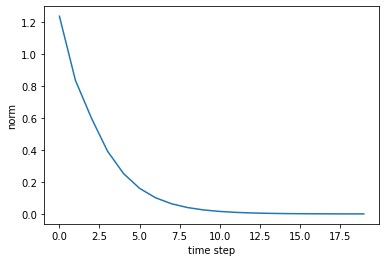

In [6]:
#역전파시 MAtMul 기울기 감소 정도 확인
N = 2  #미니배치 크기
H = 3 #은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) #재현할 수 있도록 난수의 시드 고정
#Wh = np.random.randn(H, H) #변경 전 -> 기울기 폭발 
Wh = np.random.randn(H, H) * 0.5 #변경 후 -> 기울기 소실

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N #미니배치(N개)의 평균 L2노름을 구해 dh크기로 사용
    norm_list.append(norm)

plt.plot(norm_list)
plt.xlabel("time step")
plt.ylabel("norm")




In [7]:
#기울기 클리핑 : 기울기 폭발의 대책 
#기울기를 다 모은 벡터의 크기가 threshold를 넘지 않게 하는 알고리즘
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0 #threshold = 경계값

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate



In [8]:
#LSTM 구현
#x : (N x D ), Wx : (D X 4H),  Wh : H x 4H,  h_prev : N X H,  A(affine 후의 행렬) : (N X 4H)
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b) ] #Wx, Wh, b에는 4개(f, g, i, o)분의 가중치가 담겨있음
        self.cache = None #cache는 순전파 때 중간 결과를 보관했다가 역전파 계산에 사용하려는 용도의 인스턴스 변수이다.
        
    def forward(self, x, h_prev, c_prev): # x: 현시간의 입력, h_prev : 이전 시각의 은닉 상태 c_prev: 이전 시각의 기억셀
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        #slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

        
        

In [1]:
#TimeLSTM 구현
#다시 보기 
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b) ]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype = 'f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype = 'f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c =  layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype = 'f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs 
        
    def set_state(self, h, c= None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None
        
        
        

In [4]:
#Time LSTM을 Time RNN대신에 사용하는 언어모델 
class Rnnlm:
    def __init__(self, vocab_size = 10000, wordvec_size = 100, hidden_size = 100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        #가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D).astype('f'))
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        #계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        #모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs): #Softmax 계층 직전까지를 처리, 여기서 forward는 아래의 forward 메서드를 사용하는게 아님 주의하기!
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss= self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name = 'Rnnlm.pkl'): #매개변수 쓰기 
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name = 'Rnnlm.pkl'): #매개변수 읽기
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)
        
        

Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.37
| 에폭 1 |  반복 21 / 1327 | 시간 6[s] | 퍼플렉서티 2714.03
| 에폭 1 |  반복 41 / 1327 | 시간 12[s] | 퍼플렉서티 1271.39
| 에폭 1 |  반복 61 / 1327 | 시간 17[s] | 퍼플렉서티 942.39
| 에폭 1 |  반복 81 / 1327 | 시간 23[s] | 퍼플렉서티 777.32
| 에폭 1 |  반복 101 / 1327 | 시간 29[s] | 퍼플렉서티 643.02
| 에폭 1 |  반복 121 / 1327 | 시간 35[s] | 퍼플렉서티 631.21
| 에폭 1 |  반복 141 / 1327 | 시간 41[s] | 퍼플렉서티 593.99
| 에폭 1 |  반복 161 / 1327 | 시간 47[s] | 퍼플렉서티 548.04
| 에폭 1 |  반복 181 / 1327 | 시간 52[s] | 퍼플렉서티 578.54
| 에폭 1 |  반복 201 / 1327 | 시간 58[s] | 퍼플렉서티 485.43
| 에폭 1 |  반복 221 / 1327 | 시간 64[s] | 퍼플렉서티 481.10
| 에폭 1 |  반복 241 / 1327 | 시간 69[s] | 퍼플렉서티 439.07
| 에폭 1 |  반복 261 / 1327 | 시간 75[s] | 퍼플렉서티 451.26
| 에폭 1 |  반복 281 / 1327 | 시간 81[s] | 퍼플렉서티 445.81
| 에폭 1 |  반복 301 / 1327 | 시간 87[s] | 퍼플렉서티 384.88
| 에폭 1 |  반복 321 / 1327 | 시간 92[s] | 퍼플렉서티 339.34
| 에폭 1 |  반복 341 / 1327 | 시간 98[s] | 퍼플렉서티 389.68
| 에폭 1 |  반복 361 / 1327 | 시간 104[s] | 퍼플렉서티 401.19
| 에폭 1 |  반복 381 / 1327 | 시간 110[s] | 퍼플렉서티 323.3

| 에폭 3 |  반복 521 / 1327 | 시간 1018[s] | 퍼플렉서티 136.34
| 에폭 3 |  반복 541 / 1327 | 시간 1024[s] | 퍼플렉서티 135.87
| 에폭 3 |  반복 561 / 1327 | 시간 1031[s] | 퍼플렉서티 116.72
| 에폭 3 |  반복 581 / 1327 | 시간 1037[s] | 퍼플렉서티 105.25
| 에폭 3 |  반복 601 / 1327 | 시간 1044[s] | 퍼플렉서티 148.67
| 에폭 3 |  반복 621 / 1327 | 시간 1051[s] | 퍼플렉서티 142.14
| 에폭 3 |  반복 641 / 1327 | 시간 1058[s] | 퍼플렉서티 128.75
| 에폭 3 |  반복 661 / 1327 | 시간 1064[s] | 퍼플렉서티 119.15
| 에폭 3 |  반복 681 / 1327 | 시간 1071[s] | 퍼플렉서티 99.80
| 에폭 3 |  반복 701 / 1327 | 시간 1079[s] | 퍼플렉서티 118.28
| 에폭 3 |  반복 721 / 1327 | 시간 1086[s] | 퍼플렉서티 125.09
| 에폭 3 |  반복 741 / 1327 | 시간 1094[s] | 퍼플렉서티 106.92
| 에폭 3 |  반복 761 / 1327 | 시간 1100[s] | 퍼플렉서티 104.46
| 에폭 3 |  반복 781 / 1327 | 시간 1107[s] | 퍼플렉서티 104.85
| 에폭 3 |  반복 801 / 1327 | 시간 1114[s] | 퍼플렉서티 114.48
| 에폭 3 |  반복 821 / 1327 | 시간 1122[s] | 퍼플렉서티 115.71
| 에폭 3 |  반복 841 / 1327 | 시간 1129[s] | 퍼플렉서티 113.84
| 에폭 3 |  반복 861 / 1327 | 시간 1135[s] | 퍼플렉서티 119.55
| 에폭 3 |  반복 881 / 1327 | 시간 1142[s] | 퍼플렉서티 106.45
| 에폭 3 |  반복 

C:\Users\vhbncm\Anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vhbncm\Anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vhbncm\Anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vhbncm\Anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vhbncm\Anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47113 (\N{HANGUL SYLLABLE REG}) missing from current font.
  fig.

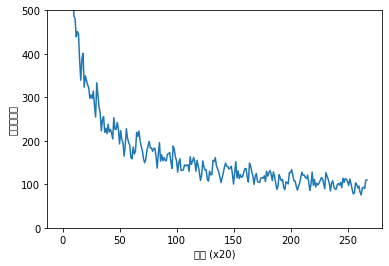

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼블렉서티:  136.04499499750656


In [7]:
#위 신경망을 사용해 PTB 데이터셋을 학습시키

#하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100 #RNN의 은닉상태 벡터의 원소 수
time_size = 35 #RNN을 펼치는 크기
lr =  20.0
max_epoch = 4
max_grad = 0.25

#학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

#모델 생성
#vocab_size : 전체 단어의 수
#wordvec_size : 관심 대상 단어의 수 = embedding 후의 단어 수 
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

#1. 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval = 20)
trainer.plot(ylim = (0, 500))

#2. 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼블렉서티: ', ppl_test)

#3. 매개변수 저장
model.save_params()


In [11]:
class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size = 10000, wordvec_size = 650, hidden_size = 650, dropout_ratio = 0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        #가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D).astype('f'))
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H).astype('f'))
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        #계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(droupout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful = True),
            TimeDropout(droupout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful = True), #3. LSTM계층의 다층화
            TimeDropout(droupout_ratio),     #2.dropout 계층 넣기 (overfitting 방지)        
            TimeAffine(embed_W.T, affine_b) #1.가중치 공유 
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        #모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_flg = False): #Softmax 계층 직전까지를 처리, 여기서 forward는 아래의 forward 메서드를 사용하는게 아님 주의하기!
        for layer in self.drop_layers:
            layer.train_flg = train.flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss= self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()
        
    def save_params(self, file_name = 'Rnnlm.pkl'): #매개변수 쓰기 
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name = 'Rnnlm.pkl'): #매개변수 읽기
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)
        
        

In [14]:
#하이퍼파라미터 설정
#cpu로 2일 gpu로 5시간 걸림.
batch_size = 20
wordvec_size = 650
hidden_size = 650 #RNN의 은닉상태 벡터의 원소 수
time_size = 35 #RNN을 펼치는 크기
lr =  20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

#학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

#모델 생성
#vocab_size : 전체 단어의 수
#wordvec_size : 관심 대상 단어의 수 = embedding 후의 단어 수 
model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch = 1, batch_size = batch_size,
               time_size =  time_size, max_grad = max_grad)
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼블렉서티: ', ppl)
    
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
    
    model.reset_state()
    print('-' * 50)
    

Done
| 에폭 1 |  반복 1 / 1327 | 시간 2[s] | 퍼플렉서티 9999.82


KeyboardInterrupt: 

In [15]:
#Attention 
#맥락벡터 구하기
T, H = 5, 4 # T: 시계열의 길이 H: 은닉 상태 벡터의 원소 수
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5, 1).repeat(4, axis = 1)
print(ar.shape)

t = hs * ar # hs의 각각의 행벡터는 하나의 단어의 원핫벡터이고 이를 각각 a의 열벡터와 내적시켜 c의 원소를 구한다.  
print(t.shape)

c = np.sum(t, axis = 0)
print(c.shape)

# Tip : axis= 1이면 (5 , 4) -> (5, )가 됨 

(5, 4)
(5, 4)
(4,)


In [16]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis = 2)
#ar = a.reshape(N, T, 1) # 브로드캐스트를 사용하는 경우

t = hs * ar
print(t.shape)
#(10, 5, 4)

c = np.sum(t, axis = 1)
print(c.shape)
#(10, 4)


(10, 5, 4)
(10, 4)


In [ ]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
    
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis = 2)
        t = hs * ar
        c = np.sum(t, axis = 1)
        
        self.cache = (hs, ar)
        return c
    def backward(self, dc):
        hs , ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis = 1) #sum의 역전파 
        
        
        
        
        
        
        